# Udacity CarND Term1 Proj4 Advanced Lane Finding resubmitted
* Joe Zhou
* ibalpowr@gmail.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

%matplotlib inline

import pickle

from collections import deque

In [2]:
cd /ibalpowr/workbench/term1-proj4

/ibalpowr/workbench/term1-proj4


# camera calibration
* using multiple different views of a (9,6) chessboard
* cv2.findChessboardCorners()
* cv2.drawChessboardCorners() ... used to debug only
* cv2.calibrateCamera()
* cv2.undistort()

### import calibration images

In [3]:
chessboard_images = glob.glob('camera_cal/*.jpg')
# if necessary ... copy the calibration images folder

<class 'list'>
20


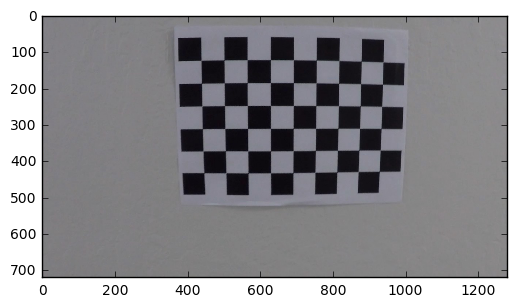

In [4]:
# display an example of calibration image
print(type(chessboard_images))
print(len(chessboard_images))
plt.imshow(mpimg.imread(chessboard_images[0]))
plt.show()

In [5]:
# check the image dimensions
h,w,d = mpimg.imread(chessboard_images[0]).shape
print(h,w,d)

720 1280 3


### the geometry of the chessboard is known
* i.e. the chessboard structure is known
* i.e. the number of rows and number of columns are known
* chessboard poses are o.k. to be unknown in calibration images
    * but should be in landscape, not portrait
    * evenly split to left, right, and direct facing

In [6]:
nx = 9  # no. of interior square (chessboard) grid 
        # intersects (corners) in a row
ny = 6  # no. of interior square (chessboard) grid 
        # intersects (corners) in a column

In [7]:
grids = np.zeros((nx*ny, 3), np.float32)
print(grids.shape)

(54, 3)


In [8]:
grids[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
print(grids.shape)

(54, 3)


In [9]:
# define some holders
objectPoints = []
imagePoints = []
calibration_images_found = []
calibration_images_not_found = []

In [10]:
# find corners
for i, chessboard in enumerate(chessboard_images):
    image = mpimg.imread(chessboard)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if found:
        imagePoints.append(corners)
        objectPoints.append(grids)
        cv2.drawChessboardCorners(image,(nx,ny), corners, True)
        calibration_images_found.append(image)
    else:
        calibration_images_not_found.append(image)

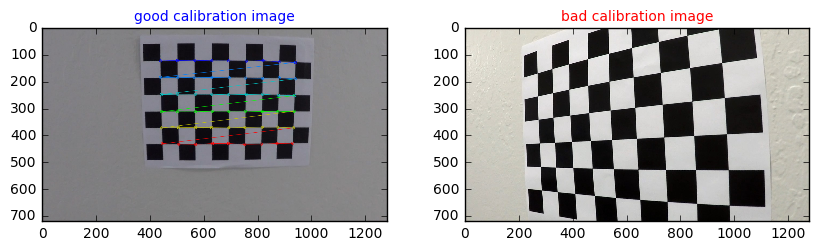

In [11]:
# show one example for each good and bad calibrations
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,2.5))
ax1.imshow(calibration_images_found[0])
ax1.set_title('good calibration image', fontsize=10, color='blue')
ax2.imshow(calibration_images_not_found[0])
ax2.set_title('bad calibration image', fontsize=10, color='red')

### check calibration results

In [12]:
len(imagePoints)

17

In [13]:
# 9 * 6 = 54
imagePoints[0].shape

(54, 1, 2)

In [14]:
# display coordinates of first two corners
imagePoints[0][:2,:,:]

array([[[ 437.5       ,  125.        ]],

       [[ 499.71313477,  123.50114441]]], dtype=float32)

### find camera matrix and distortion coefficients

In [15]:
camera_matrix = None
distortion_coefficients = None
imageSize = (h,w)

In [16]:
_, camera_matrix, distortion_coefficients, _, _ = \
            cv2.calibrateCamera(objectPoints,
                                imagePoints,imageSize,None,None)

In [17]:
print(type(camera_matrix))
print(camera_matrix.shape)

<class 'numpy.ndarray'>
(3, 3)


In [18]:
# four intrinsic parameters: fx,fy,cx,cy
# all in pixel unit
# cx,cy initialized from half of imageSize
# fx,fx guessed from lens focal length indirectly
camera_matrix
# fx   0   cx
# 0    fy  cy
# 0    0   1

array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
       [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [19]:
print(type(distortion_coefficients))
print(distortion_coefficients.shape)

<class 'numpy.ndarray'>
(1, 5)


In [20]:
distortion_coefficients
# five parameters: k1,k2,p1,p2,k3
    # for fisheye lenses
# k1,k2,k3 for radial distortion
# p1,p2 for tangential distortion

array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,
         -1.28285248e-04,   2.67027151e-02]])

### save the calibration model

In [21]:
camcal_model = [camera_matrix, distortion_coefficients]
pickle.dump(camcal_model, open('camera_calibration_model.pkl', 'wb'))
# the old file will be replaced without warning

### cv2.undistort()
* apply distortion_coefficients to not_found calibration images

In [22]:
undistorted_images = []
for image in calibration_images_not_found:
    undistorted = cv2.undistort(image,camera_matrix,
                                distortion_coefficients,
                                None,camera_matrix)
    undistorted_images.append(undistorted)

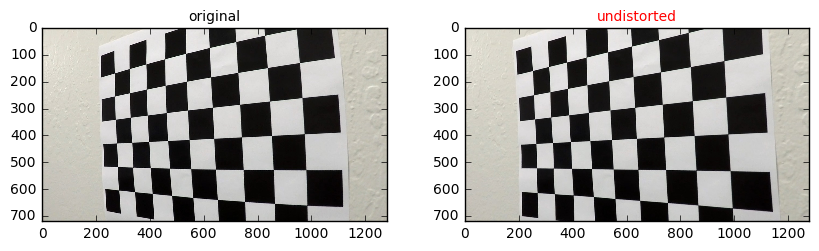

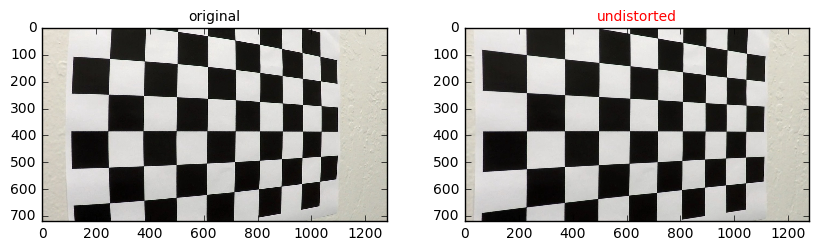

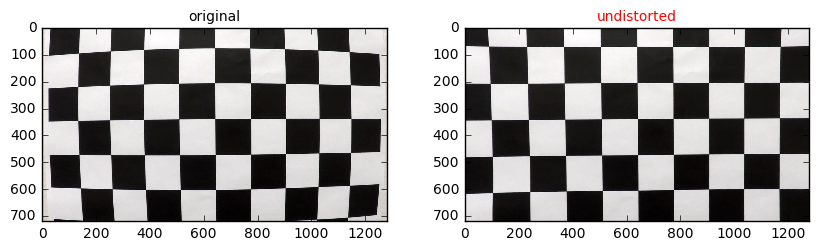

In [23]:
for i in range(len(undistorted_images)):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,2.5))
    ax1.imshow(calibration_images_not_found[i])
    ax1.set_title('original', fontsize=10)
    ax2.imshow(undistorted_images[i])
    ax2.set_title('undistorted', fontsize=10, color='red')

In [24]:
# also undistort all camera calibration images to camera_cal-undistorted folder
for image_name in glob.glob('camera_cal/*.jpg'):
    image = mpimg.imread(image_name)
    undistorted = cv2.undistort(image, camera_matrix,
                          distortion_coefficients, None,
                          camera_matrix)
    mpimg.imsave(image_name.replace('camera_cal', 
                                    'camera_cal-undistorted'), undistorted)

# load camera calibration model

In [25]:
camera_matrix = None
distortion_coefficients = None
[camera_matrix, distortion_coefficients] = pickle.load(
    open('camera_calibration_model.pkl', 'rb'))

# gradients and color masks
* the next cell can be exported as a file, "gradients_and_color_mask.py"

In [26]:
import cv2
import numpy as np
def gradients_and_color_mask(calibrated):
    
    # HLS cylinder and Saturation channel
    HLS = cv2.cvtColor(np.copy(calibrated), 
                       cv2.COLOR_RGB2HLS).astype(np.float)
    saturation = HLS[:,:,2]
    
    # sobel_x
    kernel_size = 3
    sobel_x = np.absolute(cv2.Sobel(saturation, cv2.CV_64F, 
                                    1, 0, ksize=kernel_size))
    # scale to range of [0,255] then convert to np.uint8
    sobel_x_uint8 = np.uint8(255 * (sobel_x/np.max(sobel_x)))
    
    # mask_x
    mask_x = np.zeros_like(sobel_x_uint8)
    # similar to canny, low to high ratio is 1:5
    threshold_low = 20
    threshold_high = 100
    mask_x[(sobel_x_uint8 >= threshold_low) & 
           (sobel_x_uint8 <=threshold_high)] = 1
    
    # sobel_y
    sobel_y = np.absolute(cv2.Sobel(saturation, cv2.CV_64F, 
                                    0, 1, ksize=kernel_size))
    # scale to range of [0,255] then convert to np.uint8
    sobel_y_uint8 = np.uint8(255 * (sobel_y/np.max(sobel_y)))
    
    # mask_y
    mask_y = np.zeros_like(sobel_y_uint8)
    mask_y[(sobel_y_uint8 >= threshold_low) & 
           (sobel_y_uint8 <=threshold_high)] = 1
    
    # sobel_mag
    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # scale to range of [0,255] then convert to np.uint8
    sobel_mag_uint8 = np.uint8(255 * (sobel_mag/np.max(sobel_mag)))
    
    # mask_mag
    mask_mag = np.zeros_like(sobel_mag_uint8)
    mask_mag[(sobel_mag_uint8 >= threshold_low) & 
             (sobel_mag_uint8 <=threshold_high)] = 1
    
    # scharr_direction
    # scharr is better than sobel(3x3 kernel) in handling noises
    scharr_x = np.absolute(cv2.Scharr(saturation, cv2.CV_64F, 1, 0))
    scharr_y = np.absolute(cv2.Scharr(saturation, cv2.CV_64F, 0, 1))
    scharr_direction=np.arctan2(scharr_y,scharr_x)
    
    # mask_direction
    # low to high ratio is about 1:2
    threshold_low_direction = 0.7
    threshold_high_direction = 1.3
    mask_direction = np.zeros_like(scharr_direction)
    mask_direction[(scharr_direction >= threshold_low_direction) & 
                   (scharr_direction <= threshold_high_direction)] = 1
    
    # mask_color
    # from upper half saturated to full saturated
    threshold_low_color = 170
    threshold_high_color = 255
    mask_color = np.zeros_like(saturation)
    mask_color[(saturation >= threshold_low_color) & 
               (saturation <= threshold_high_color)] = 1
    
    # mask_gradient
    mask_gradient = np.zeros_like(saturation)
    mask_gradient[((mask_x==1)&(mask_y==1))| 
                  ((mask_mag==1)&(mask_direction==1))]=1
    
    # mask_total
    mask_total = np.zeros_like(saturation)
    mask_total[(mask_gradient==1)|(mask_color==1)] = 1
    
    return saturation, mask_total

In [27]:
from gradients_and_color_mask import gradients_and_color_mask

### how saturation channel looks like

In [28]:
image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/test1.jpg')

In [29]:
calibrated = cv2.undistort(image, camera_matrix,
                          distortion_coefficients, None,
                          camera_matrix)

In [30]:
HLS=cv2.cvtColor(np.copy(calibrated), 
                 cv2.COLOR_RGB2HLS).astype(np.float)
saturation = HLS[:,:,2]

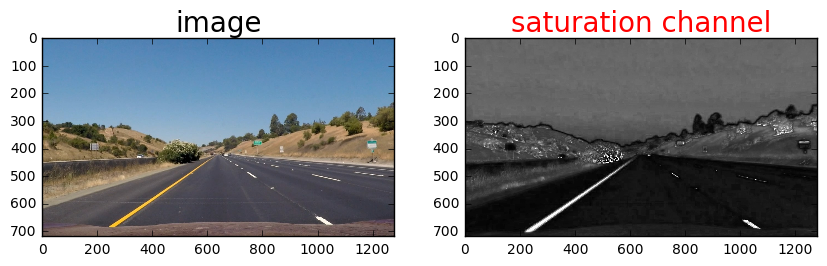

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(image)
ax1.set_title('image', fontsize= 20)
ax2.imshow(saturation,cmap='gray')
ax2.set_title('saturation channel', fontsize = 20, color='red')

### sobel_x

In [32]:
kernel_size = 3

In [33]:
sobel_kernel_x =np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
print(sobel_kernel_x)
# x axis gradients ... for vertical lines/edges

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


In [34]:
sobel_x=np.absolute(cv2.Sobel(saturation,cv2.CV_64F, 
                              1,0,ksize=kernel_size))
# scale to range of [0,255] then convert to np.uint8
sobel_x_uint8 = np.uint8(255 * (sobel_x/np.max(sobel_x)))

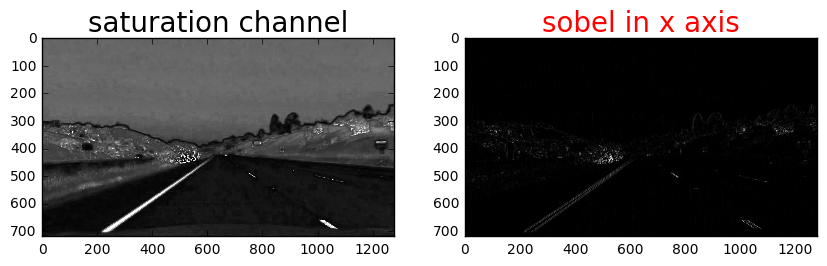

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(sobel_x_uint8,cmap='gray')
ax2.set_title('sobel in x axis', fontsize = 20, color='red')

### mask_x

In [36]:
mask_x = np.zeros_like(sobel_x_uint8)
threshold_low = 20
threshold_high = 100

In [37]:
mask_x[(sobel_x_uint8 >= threshold_low) & 
       (sobel_x_uint8 <=threshold_high)] = 1

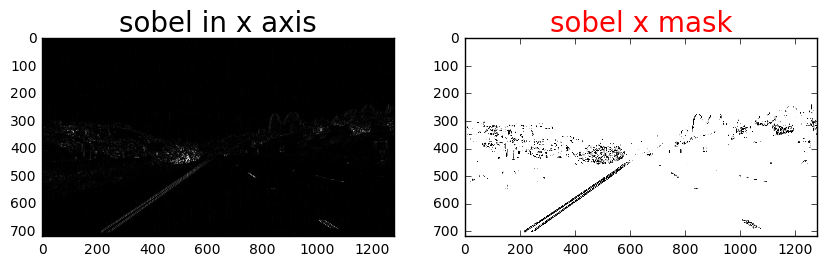

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(sobel_x_uint8,cmap='gray')
ax1.set_title('sobel in x axis', fontsize= 20)
ax2.imshow(mask_x,cmap='binary')
ax2.set_title('sobel x mask', fontsize = 20, color='red')

### sobel_y

In [39]:
sobel_y=np.absolute(cv2.Sobel(saturation,cv2.CV_64F, 
                              0,1,ksize=kernel_size))
# scale to range of [0,255] then convert to np.uint8
sobel_y_uint8 = np.uint8(255 * (sobel_y/np.max(sobel_y)))

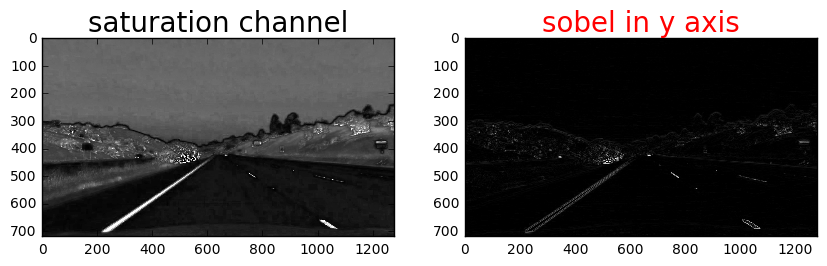

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(sobel_y_uint8,cmap='gray')
ax2.set_title('sobel in y axis', fontsize = 20, color='red')

### mask_y

In [41]:
mask_y = np.zeros_like(sobel_y)
mask_y[(sobel_y_uint8 >= threshold_low) & 
       (sobel_y_uint8 <=threshold_high)] = 1

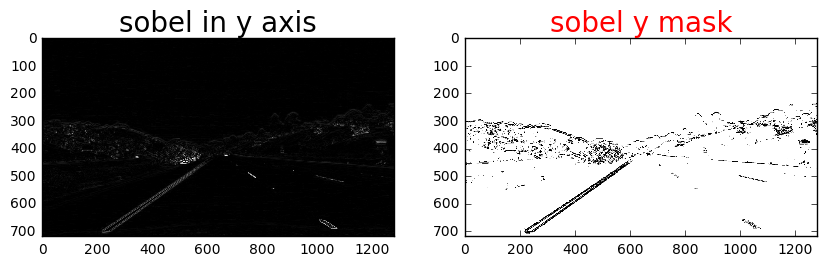

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(sobel_y_uint8,cmap='gray')
ax1.set_title('sobel in y axis', fontsize= 20)
ax2.imshow(mask_y,cmap='binary')
ax2.set_title('sobel y mask', fontsize = 20, color='red')

### sobel_mag

In [43]:
sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
# scale to range of [0,255] then convert to np.uint8
sobel_mag_uint8 = np.uint8(255 * (sobel_mag/np.max(sobel_mag)))

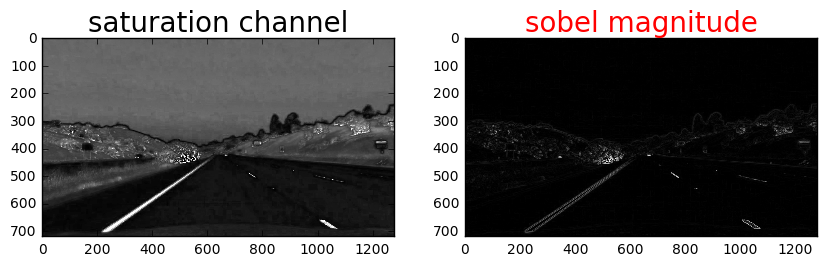

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(sobel_mag_uint8,cmap='gray')
ax2.set_title('sobel magnitude', fontsize = 20, color='red')

### mask_mag

In [45]:
mask_mag = np.zeros_like(sobel_mag)
mask_mag[(sobel_mag_uint8 >= threshold_low) & 
         (sobel_mag_uint8 <=threshold_high)] = 1

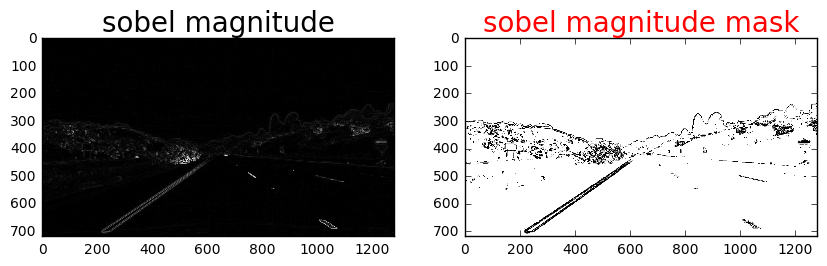

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(sobel_mag_uint8,cmap='gray')
ax1.set_title('sobel magnitude', fontsize= 20)
ax2.imshow(mask_mag,cmap='binary')
ax2.set_title('sobel magnitude mask', fontsize = 20, color='red')

### scharr_direction

In [47]:
scharr_kernel_x =np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
print(scharr_kernel_x)

[[ -3   0   3]
 [-10   0  10]
 [ -3   0   3]]


In [48]:
scharr_x = np.absolute(cv2.Scharr(saturation, cv2.CV_64F, 1, 0))
scharr_y = np.absolute(cv2.Scharr(saturation, cv2.CV_64F, 0, 1))
scharr_direction=np.arctan2(scharr_y,scharr_x)

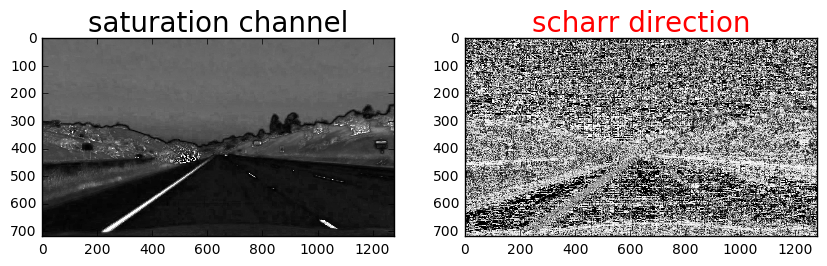

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(scharr_direction,cmap='gray')
ax2.set_title('scharr direction', fontsize = 20, color='red')

### mask_direction

In [50]:
threshold_low_direction = 0.7
threshold_high_direction = 1.3
mask_direction = np.zeros_like(scharr_direction)

In [51]:
mask_direction[(scharr_direction >= threshold_low_direction) & 
               (scharr_direction <= threshold_high_direction)] = 1

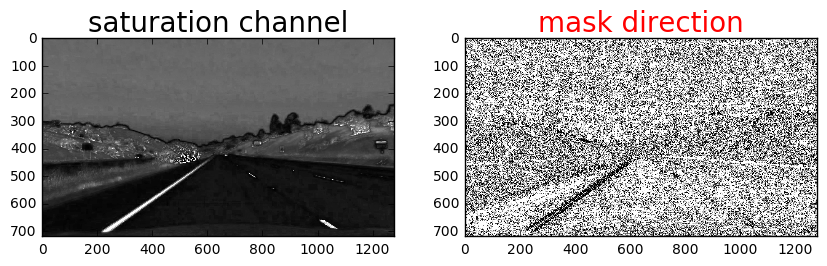

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(mask_direction,cmap='binary')
ax2.set_title('mask direction', fontsize = 20, color='red')

### mask_color
* on saturation channel

In [53]:
threshold_low_color = 170
threshold_high_color = 255
mask_color = np.zeros_like(saturation)

In [54]:
mask_color[(saturation >= threshold_low_color) & 
           (saturation <= threshold_high_color)] = 1

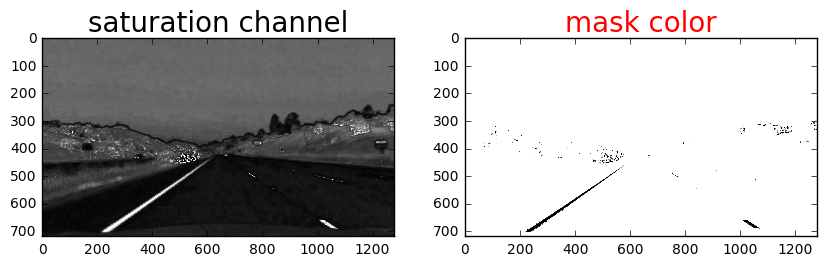

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(mask_color,cmap='binary')
ax2.set_title('mask color', fontsize = 20, color='red')

### mask_gradient

In [56]:
mask_gradient = np.zeros_like(saturation)
mask_gradient[((mask_x==1)&(mask_y==1))|((mask_mag==1)& 
                                         (mask_direction==1))]=1

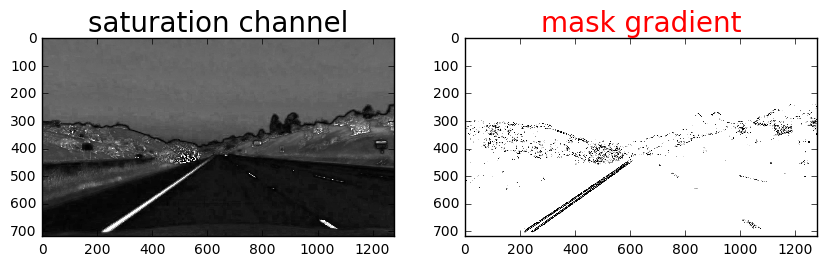

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(mask_gradient,cmap='binary')
ax2.set_title('mask gradient', fontsize = 20, color='red')

### mask_total

In [58]:
mask_total = np.zeros_like(saturation)
mask_total[(mask_gradient==1)|(mask_color==1)] = 1

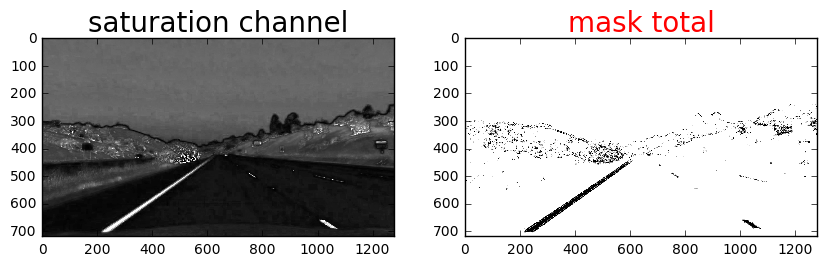

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(saturation,cmap='gray')
ax1.set_title('saturation channel', fontsize= 20)
ax2.imshow(mask_total,cmap='binary')
ax2.set_title('mask total', fontsize = 20, color='red')

# bird's-eye view
* the following cell can be exported as an external file, "perspective_transform.py"
* cv2.getPerspectiveTransform() => cv2.warpPerspective()
    * homography matrix => bird's-eye view ... a frontal parallel
* input image should be mask_total
* required in sensor fusion with lidar/radar

In [60]:
import numpy as np
import cv2

def perspective_transform(image):

    h = image.shape[0]
    w = image.shape[1]

    # provide four point correspondences
    knob = 65   # a parameter to make lane marks parallel in dst image
    y_top = 450   # kind of at where the horizon is
    
    # four points from the source
    # start w/ top left, then clockwise
    src_pt_top_left = (w//2-knob, y_top)
    src_pt_top_right = (w//2+knob, y_top)
    src_pt_bot_right = (w, h)
    src_pt_bot_left = (0,h)
    
    src = np.float32([src_pt_top_left, src_pt_top_right,
                      src_pt_bot_right, src_pt_bot_left])
    
    # four poinst from the destination
    # start w/ top left, then clockwise
    dst_pt_top_left = (knob,0)
    dst_pt_top_right = (w-knob,0)
    dst_pt_bot_right = (w-knob,h)
    dst_pt_bot_left = (knob,h)
    
    dst = np.float32([dst_pt_top_left, dst_pt_top_right,
                      dst_pt_bot_right, dst_pt_bot_left])
    
    # get homography matrix
    H_matrix = cv2.getPerspectiveTransform(src, dst)
    H_inv = cv2.getPerspectiveTransform(dst, src)
    
    # return warped frontal parallel, H_matrix, H_inv
    return (cv2.warpPerspective(image,H_matrix,(w,h)),H_matrix,H_inv)

In [61]:
from perspective_transform import perspective_transform

### provide an example

In [62]:
frontal_parallel, H_matrix, H_inv = perspective_transform(mask_total)

In [63]:
print(H_matrix)
print()
print(H_inv)

[[ -6.43656716e-01  -1.52570481e+00   1.05194030e+03]
 [ -4.66293670e-15  -1.91044776e+00   8.59701493e+02]
 [ -7.37257477e-18  -2.38391376e-03   1.00000000e+00]]

[[  1.13043478e-01  -7.98611111e-01   5.67652174e+02]
 [  5.99520433e-15  -5.23437500e-01   4.50000000e+02]
 [  9.10729825e-18  -1.24782986e-03   1.00000000e+00]]


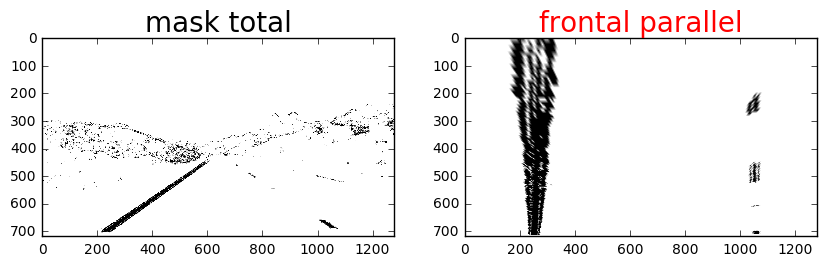

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.imshow(mask_total, cmap='binary')
ax1.set_title('mask total', fontsize= 20)
ax2.imshow(frontal_parallel, cmap='binary')
ax2.set_title('frontal parallel', fontsize = 20, color='red')

In [65]:
frontal_parallel

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Sliding_Window class

In [66]:
class Sliding_Window(object):
    def __init__(self, y1, y2, x, spread=80, tuple_count_threshold=50):
        self.x = x
        self.x_next = x
        self.y1 = y1
        self.y2 = y2
        self.spread = spread
        self.tuple_count_threshold = tuple_count_threshold

    def find_tuple_pos(self, nonzero, x=None):
        if x is not None:
            self.x = x 
        x1 = self.x - self.spread
        x2 = self.x + self.spread
        
        tuple_pos = ((nonzero[0] >= self.y1) & 
                     (nonzero[0] < self.y2) & 
                     (nonzero[1] >= x1) & 
                     (nonzero[1] < x2)).nonzero()[0]
        
        # if the number of tuples is greater than the threshold,
        # then next x is assigned to the mean of x coordinates of
        # those tuples.
        # if not, next x is same as current x
        self.x_next = np.int(np.mean(nonzero[1][tuple_pos])) \
                        if len(tuple_pos) > self.tuple_count_threshold \
                        else self.x

        return tuple_pos

    def coordinates(self):
        x1 = self.x - self.spread
        x2 = self.x + self.spread
        return ((x1, self.y1), (x2, self.y2))

In [67]:
h,w = frontal_parallel.shape
print(h,w)

720 1280


In [68]:
# count no. of 1's on the lower half of the image along x axis
histogram = np.sum(frontal_parallel[h//2:, :], axis=0)
print(histogram)

[ 0.  0.  0. ...,  0.  0.  0.]


In [69]:
# get a tuple of two arrays
# one array is the x coordinates of all nonzero pixels
# the other array is the y coordinates of all nonzero pixels
nonzero = frontal_parallel.nonzero()

In [70]:
type(nonzero)

tuple

In [71]:
nonzero

(array([  0,   0,   0, ..., 716, 716, 716]),
 array([181, 182, 183, ..., 266, 267, 268]))

In [72]:
len(nonzero[0])

87625

In [73]:
print(nonzero[0][0], nonzero[1][0])
print(frontal_parallel[nonzero[0][0], nonzero[1][0]])

0 181
0.125


In [74]:
print(nonzero[0][87624], nonzero[1][87624])
print(frontal_parallel[nonzero[0][87624], nonzero[1][87624]])

716 268
0.041015625


In [75]:
# create an empty array for tuple position on left or right lane marks
tuple_position_left = np.array([], dtype=np.int)
tuple_position_right = np.array([], dtype=np.int)

In [76]:
type(tuple_position_left)

numpy.ndarray

In [77]:
# assing number of sliding windows
win_n = 9
win_h = h // win_n

In [78]:
# find the x position in where the count is highest in the left or right half
x_l_argmax = np.argmax(histogram[:w // 2])
x_r_argmax = np.argmax(histogram[w // 2:]) + w // 2
print(x_l_argmax, x_r_argmax)

256 1049


In [79]:
# a list for sliding window instances on the left or right lane marks
l_windows = []
r_windows = []

In [80]:
for i in range(win_n):
    y1=h - (i + 1) * win_h
    y2=h - i * win_h
    x_l=l_windows[-1].x if len(l_windows) > 0 \
                            else x_l_argmax
    x_r=r_windows[-1].x if len(r_windows) > 0 \
                            else x_r_argmax
            
    l_window = Sliding_Window(y1,y2,x_l)
    r_window = Sliding_Window(y1,y2,x_r)
            
    tuple_position_left = np.append(tuple_position_left, 
                                    l_window.find_tuple_pos(nonzero), 
                                    axis=0)
    tuple_position_right = np.append(tuple_position_right, 
                                    r_window.find_tuple_pos(nonzero), 
                                    axis=0)
    l_windows.append(l_window)
    r_windows.append(r_window)

In [81]:
len(l_windows)

9

In [82]:
tuple_position_left

array([83429, 83430, 83431, ..., 13121, 13122, 13123])

# Lane_Marks class
* the input image should be undistorted

In [83]:
class Lane_Marks(object):
    def __init__(self, image, win_n=8):
        self.h = image.shape[0]
        self.w = image.shape[1]
        self.win_n = win_n
        
        # 
        self.coefficients_left = deque(maxlen=5)
        self.coefficients_right = deque(maxlen=5)
        
        # a list for sliding window instances on the left lane marks
        self.l_windows = []
        
        # a list for sliding window instances on the right lane marks
        self.r_windows = []
        
        self.initialize_lines(image)

    def initialize_lines(self, image):
        
        # process the whole image input
        # gradients and color masking => bird's-eye view
        _, mask_total = gradients_and_color_mask(image)
        (frontal_parallel, _, _) = perspective_transform(mask_total)
        
        # count no. of 1's on the lower half of the image along x axis
        histogram = np.sum(frontal_parallel[self.h//2:, :], axis=0)

        # get a tuple of two arrays
        # one array is the x coordinates of all nonzero pixels
        # the other array is the y coordinates of all nonzero pixels
        nonzero = frontal_parallel.nonzero()
        
        # create an empty array for tuple positions 
        # on left or right lane marks
        tuple_position_left = np.array([], dtype=np.int)
        tuple_position_right = np.array([], dtype=np.int)
        
        # find the height of a sliding window
        win_h = self.h // self.win_n
        
        # find the x position in where the count is highest 
        # in the left or right half
        x_l_argmax = np.argmax(histogram[:self.w // 2])
        x_r_argmax = np.argmax(histogram[self.w // 2:]) + self.w // 2

        # initialize each sliding windows
        for i in range(self.win_n):
            y1=self.h - (i + 1) * win_h
            y2=self.h - i * win_h
            x_l=self.l_windows[-1].x if len(self.l_windows) > 0 \
                                    else x_l_argmax
            x_r=self.r_windows[-1].x if len(self.r_windows) > 0 \
                                    else x_r_argmax
            
            l_window = Sliding_Window(y1,y2,x_l)
            r_window = Sliding_Window(y1,y2,x_r)
            
            tuple_position_left = np.append(tuple_position_left, 
                                    l_window.find_tuple_pos(nonzero), 
                                    axis=0)
            tuple_position_right = np.append(tuple_position_right, 
                                    r_window.find_tuple_pos(nonzero), 
                                    axis=0)
            self.l_windows.append(l_window)
            self.r_windows.append(r_window)
        
        # find curve coefficients on the left
        x_line_left = nonzero[1][tuple_position_left]
        y_line_left = nonzero[0][tuple_position_left]
        self.find_coefficients(x_line_left, y_line_left, 
                            self.coefficients_left)

        # find curve coefficients on the right
        x_line_right = nonzero[1][tuple_position_right]
        y_line_right = nonzero[0][tuple_position_right]
        self.find_coefficients(x_line_right, y_line_right, 
                            self.coefficients_right)

    def scan_frontal_parallel(self, frontal_parallel, windows):
        tuple_position = np.array([], dtype=np.int)
        nonzero = frontal_parallel.nonzero()
        window_x = None
        for window in windows:
            tuple_position = np.append(tuple_position, 
                            window.find_tuple_pos(nonzero, window_x), 
                                axis=0)
            window_x = window.x_next
        nonzero_x = nonzero[1][tuple_position]
        nonzero_y = nonzero[0][tuple_position]
        return (nonzero_x,nonzero_y)

    def find_coefficients(self, x, y, coefficients):
        enough_points = len(y) > 0 and np.max(y)-np.min(y)>self.h*.625
        if enough_points or len(coefficients) == 0:
            coefficients.append(np.polyfit(y, x, 2))
    
    # the main routine
    def process(self, image, show_lane=True, 
                show_sliding_windows=False, show_info=True):
        
        # gradients/color mask => bird's-eye view
        _, mask_total = gradients_and_color_mask(image)
        (frontal_parallel, _, H_inv) = perspective_transform(mask_total)
        
        # sliding windows on the left
        (l_x, l_y) = self.scan_frontal_parallel(frontal_parallel, 
                                                self.l_windows)
        self.find_coefficients(l_x, l_y, self.coefficients_left)
        
        # sliding windows on the right
        (r_x, r_y) = self.scan_frontal_parallel(frontal_parallel, 
                                                self.r_windows)
        self.find_coefficients(r_x, r_y, self.coefficients_right)

        # to show sliding windows
        if show_sliding_windows:
            # create a regular size image with annotations
            windows_overlay = self.show_sliding_windows(frontal_parallel)
            # rescale by 0.3
            windows_overlay=cv2.resize(windows_overlay,(0,0),
                                       fx=0.3,fy=0.3)
            # make the top portion of the image transparent by 40%
            image[:250, :, :] = image[:250, :, :] * .4
            # place the overlay into the image
            (h, w, _) = windows_overlay.shape
            image[20:20 + h, 20:20 + w, :] = windows_overlay
        
        # to show curvature and distances
        if show_info:
            # text_x = 20 + 20 + w + w + 20
            text_x = 20 + 20 + 20
            curvature = int(np.average([self.radius_of_curvature\
                                        (self.coefficients_left), 
                               self.radius_of_curvature\
                                        (self.coefficients_right)]))
            self.draw_text(image, 'radius of curvature: {} m'\
                          .format(curvature), text_x, 80)
            
            left_distance = self.camera_distance(self.coefficients_left)
            right_distance = self.camera_distance(self.coefficients_right)
            deviation_from_center = (left_distance - right_distance)/2
            if deviation_from_center > 0:
                self.draw_text(image, 'vehicle is {:.2f} m right of center '\
                               .format(np.abs(deviation_from_center)),text_x,140)
            else:
                self.draw_text(image, 'vehicle is {:.2f} m left of center '\
                               .format(np.abs(deviation_from_center)),text_x,140)
                
        # to highlight lane marks
        if show_lane:
            image = self.show_lane_overlay(image, H_inv)

        return image
        
        # uncomment to the sliding window image
        #return windows_overlay

    def show_sliding_windows(self, binary, lines=True, windows=True):
        
        if len(binary.shape) == 2:
            image = np.dstack((binary, binary, binary))
        else:
            image = binary
        if windows:
            
            # show sliding windows on the left
            for window in self.l_windows:
                coordinates = window.coordinates()
                cv2.rectangle(image, coordinates[0], 
                              coordinates[1], (0., 0., 1), 4)
                
            # show sliding windows on the right
            for window in self.r_windows:
                coordinates = window.coordinates()
                cv2.rectangle(image, coordinates[0], 
                              coordinates[1], (0., 0., 1), 4)
        if lines:
            cv2.polylines(image, 
                          [self.get_points(self.coefficients_left)], 
                          False, (1., 0, 0), 10)
            cv2.polylines(image, 
                          [self.get_points(self.coefficients_right)], 
                          False, (1., 0, 0), 10)
        
        return image * 255
        
        # uncomment below to show larger sliding window
        #return image

    # returns all points (x,y) of lane marks curve    
    def get_points(self, coefficients):
        y = np.linspace(0, self.h - 1, self.h)
        coeff_mean = np.array(coefficients).mean(axis=0)
        x = coeff_mean[0] * y ** 2 + coeff_mean[1] * y + coeff_mean[2]
        return np.stack((x,y)).astype(np.int).T    

    def draw_text(self, image, text, x, y):
        cv2.putText(image, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 
                    1, (255, 255, 255), 3)
    
    def radius_of_curvature(self,coefficients):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 27 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        points = self.get_points(coefficients)
        y = points[:, 1]
        x = points[:, 0]
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        return int(((1 + (2 * fit_cr[0] * 720 * ym_per_pix + fit_cr[1]) 
                     ** 2) ** 1.5) / np.absolute(2 * fit_cr[0]))
    
    def camera_distance(self, coefficients):
        points = self.get_points(coefficients)
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
        x = points[np.max(points[:, 1])][0]
        return np.absolute((self.w // 2 - x) * xm_per_pix)
    
    def show_lane_overlay(self, image, H_inv=None):
        overlay = np.zeros_like(image).astype(np.uint8)
        points = np.vstack((self.get_points(self.coefficients_left), 
                    np.flipud(self.get_points(self.coefficients_right))))
        cv2.fillPoly(overlay, [points], (200, 100, 50))
        if H_inv is not None:
            overlay = cv2.warpPerspective(overlay, H_inv, 
                                        (image.shape[1],image.shape[0]))
        return cv2.addWeighted(image, 1, overlay, 0.5, 0)


# for a single image

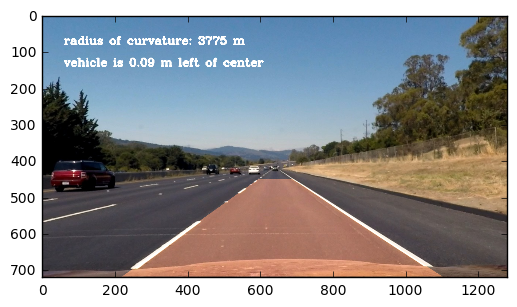

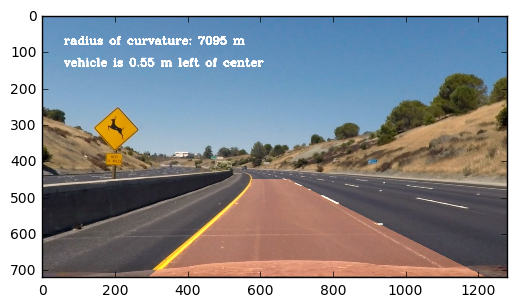

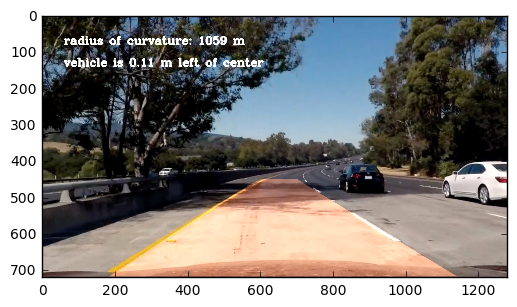

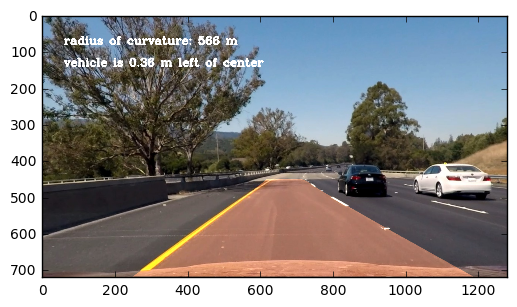

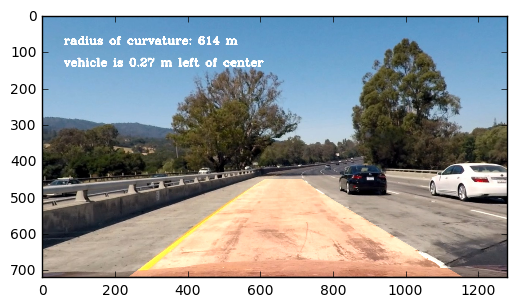

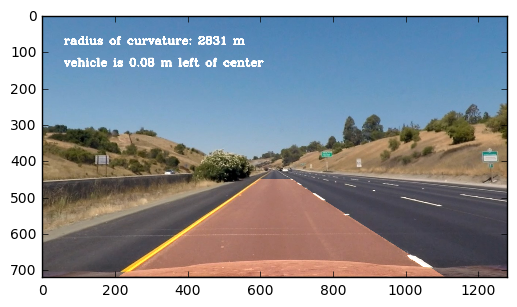

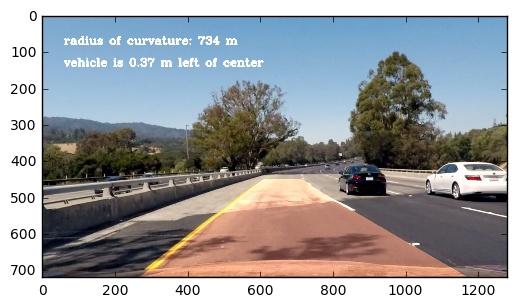

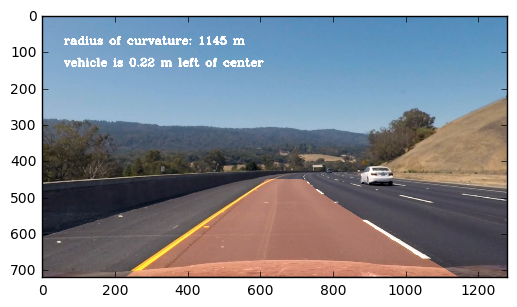

In [84]:
for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    undistorted = cv2.undistort(image, camera_matrix,
                          distortion_coefficients, None,
                          camera_matrix)
    lane_find = Lane_Marks(undistorted)
    output = lane_find.process(undistorted,show_lane=True, 
                           show_sliding_windows=False, show_info=True)
    mpimg.imsave(image_name.replace('test_images', 
                                    'output_images_resubmitted'), output)
    plt.imshow(output)
    plt.show()

In [85]:
image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/test1.jpg')

In [86]:
undistorted = cv2.undistort(image, camera_matrix,
                          distortion_coefficients, None,
                          camera_matrix)

In [87]:
lane_find = Lane_Marks(undistorted)

In [88]:
output = lane_find.process(undistorted,show_lane=True, 
                           show_sliding_windows=True, show_info=True)

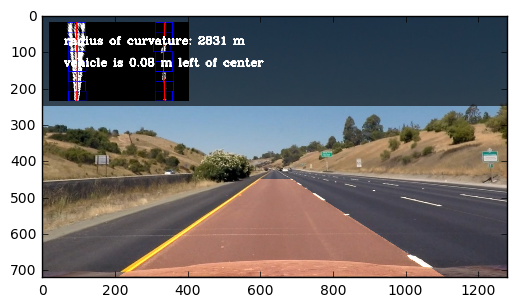

In [89]:
# spread = 80, n_win = 8
plt.imshow(output)
plt.show()

# now video

In [90]:
from moviepy.editor import VideoFileClip

video = VideoFileClip('project_video.mp4')
video_output_name = 'project_video_proj4-ibalpowr-resubmitted.mp4'

In [91]:
undistorted = cv2.undistort(video.get_frame(0), camera_matrix,
                          distortion_coefficients, None,
                          camera_matrix)

In [92]:
lane_find = Lane_Marks(undistorted)
video_output = video.fl_image(lane_find.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video project_video_proj4-ibalpowr-resubmitted.mp4
[MoviePy] Writing video project_video_proj4-ibalpowr-resubmitted.mp4


100%|█████████▉| 1260/1261 [03:19<00:00,  6.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proj4-ibalpowr-resubmitted.mp4 

CPU times: user 11min 1s, sys: 21.6 s, total: 11min 23s
Wall time: 3min 20s
